# ASE calculator

This tutorial demonstrates how to use the [ASE](https://wiki.fysik.dtu.dk/ase/) calculator for NEP with GPUMD as provided in `calorine`.
An ASE calculator lets a user calculate energies, forces and stresses for an atomic configuration, more specifically an [ASE Atoms object](https://wiki.fysik.dtu.dk/ase/ase/atoms.html).
In the present context, this makes it possible to programmatically calculate properties that would otherwise require writing a large number of GPUMD input files and tedious extraction of the results.

***Note that this tutorial assumes that GPUMD version 3.3 is installed on your machine.***


## Basic usage
We begin by creating a calculator and an `Atoms` object for which we soon will calculate potential energy, forces and stresses.
We initialize the calculator by specifying a path to the NEP model file (typically a `nep.txt` file).
In this tutorial, we use a [NEP3 model for PbTe](https://gitlab.com/brucefan1983/nep-data/-/tree/main/PbTe).
The calculator is then attached to the `Atoms` object.

In [1]:
from calorine import GPUNEP
from ase.build import bulk

atoms = bulk('PbTe', crystalstructure='rocksalt', a=6.7)
calc = GPUNEP('PbTe_NEP3.txt')
atoms.calc = calc

The stage is now set for calculation of energies, forces and stresses:

In [2]:
print('Energy (eV):', atoms.get_potential_energy())
print('Forces (eV/Å):\n', atoms.get_forces())
print('Stresses (eV/Å^3):', atoms.get_stress())

Energy (eV): -7.6810722351
Forces (eV/Å):
 [[-4.00012e-08 -4.61735e-08 -3.31625e-08]
 [ 4.00012e-08  4.61735e-08  3.31625e-08]]
Stresses (eV/Å^3): [ 4.82120785e-03  4.82120666e-03  4.82120760e-03 -1.29963668e-09
 -1.42977897e-09 -1.71918525e-09]


## Calculate energy-volume curve
To demonstrate the capabilities of the ASE calculator, we will now calculate an energy-volume curve with the PbTe potential.

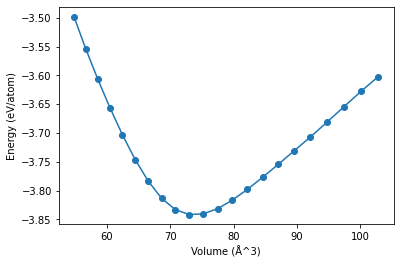

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

energies = []
volumes = []

atoms_copy = atoms.copy()
original_cell = atoms.cell.copy()

atoms_copy.calc = calc

for scale in np.arange(0.9, 1.11, 0.01):
    atoms_copy.set_cell(scale * original_cell, scale_atoms=True)
    volumes.append(atoms_copy.get_volume())
    energies.append(atoms_copy.get_potential_energy() / len(atoms_copy))

fig, ax = plt.subplots()
ax.plot(volumes, energies, '-o')
ax.set_xlabel('Volume (Å^3)')
ax.set_ylabel('Energy (eV/atom)');

## Temporary and specified directories
Under the hood, the GPUMD calculator creates a directory and writes the input files necessary to run GPUMD.
In the above examples, this was done in temporary directories that were automatically removed once the calculations finished.
It is also possible to run in a user-specified directory that will be kept after the calculations finish.

In [4]:
calc.set_directory('my_directory')
atoms.get_potential_energy()

-7.6810722351

After this is run, there should be a new directory, `my_directory`, in which input and output files from GPUMD are available.
This can be useful for debugging.

## Run custom molecular dynamics simulations
To take advantage of the Python workflow as well as raw speed of the GPU accelerated NEP implementation, the ASE calculator also contains a convenience function for running customized MD simulations.
This should typically be done in a specified directory.
The parameters of the `run.in` file are specified as a list of tuples with two elements, the first being the keyword name and the second any arguments to that keyword.

In [5]:
calc.set_directory('my_md_simulation')
supercell = atoms.repeat(5)
atoms.calc = calc
parameters = [('velocity', 300),
              ('dump_thermo', 100),
              ('dump_position', 100),
              ('ensemble', ('nvt_ber', 300, 300, 100)),
              ('run', 1000)]
calc.run_custom_md(parameters)

Once this is run, the results are available in the folder `my_md_simulations`.